In [20]:

    
suppressWarnings(library(tidyverse, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(caret, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(require(gridExtra, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(glmnet, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(cluster, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(mclust, quietly = TRUE, warn.conflicts = FALSE))

set.seed(2718281)


## In this module you will learn how to:


1. Use dimensionality reduction to visualize high dimensional data.
2. Examine principle components analysis on shopping cart data
3. Explore clustering algorithms like K-means and Gaussian Mixture Models (GMM)

## The Data


In this example we will use a sample of the InstaCart shopping dataset. This data is incredibly sparse (there are many more zeros than ones), as such we will only use the top 5,000 active users and the 997 most popular products.

Any given row in the data frame refers to whether that individual purchased a product represented in the column or not.

In [21]:
choices = read.csv('Choice_Mat.csv')
choices = choices[which(apply(choices,2,var)!=0)]
# Reads csv files into R
choices[1:5,990:997]                                                            
# Examine the first few rows of our data
cat('Dataset dimesions: ',dim(choices))                                  
# Returns the dimension of the dataset 
                                        

X992,X993,X994,X995,X996,X997,X998,X999
0,0,0,0,0,1,1,0
0,0,0,0,1,0,0,1
0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,1,0


Dataset dimesions:  5000 997

## Visualization

When the data is binary we can visualize the entire data frame using a heatmap. This will work for count data as well, so long as the counts aren't too variable. The heatmap shows us what items are most popular by including a black cell where that item was purchased by an individual.

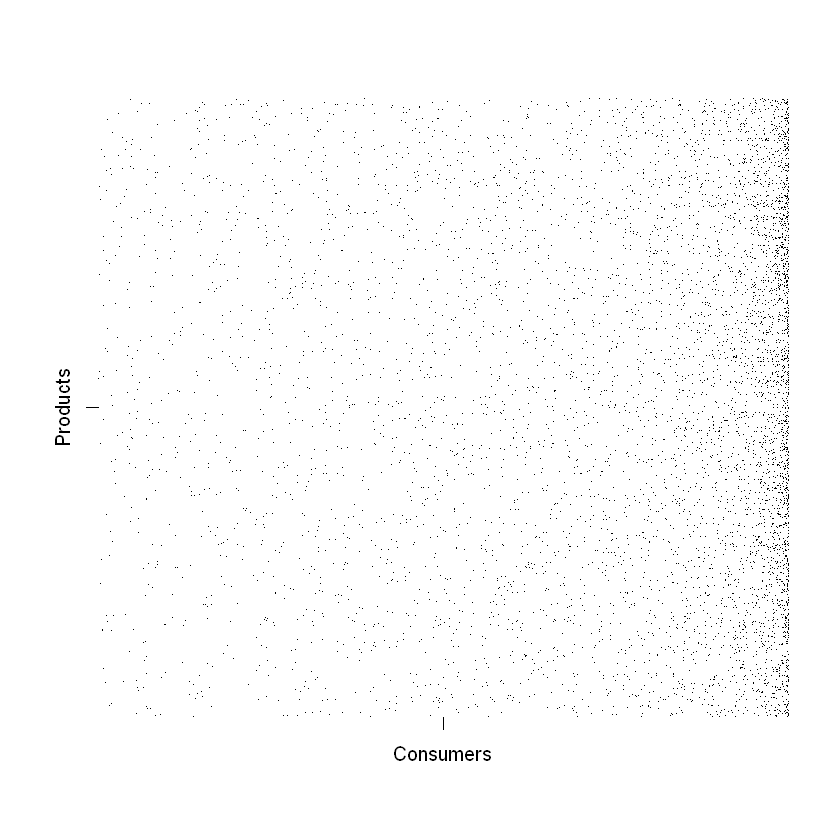

In [22]:
image(t(as.matrix(choices)),col=gray.colors(2,start=1,end=0),axes=FALSE)
axis(1,at = 0.5, label='Consumers',pos=0)
axis(2,at = 0.5,label='Products',pos=0)

The data is sorted based on the popularity, as one will observe from the density there is long tail behavior in the product purchases.

## PCA

Our goal with dimensionality reduction is to find some inherent structure in this high dimensional data that can be exploited in our further analysis. The oldest and most widely used method to do this is to use PCA (principal components analysis). Recall that PCA produces a low-dimensional linear representation of a dataset, by finding directions of maximal variance that are mutually orthogonal. In R we simply use the "prcomp" function to find this representation.


In [23]:
pca = prcomp(choices,center=FALSE)
# decompose the choice matrix and compute the principal components

## Visualizing the PCA Embedding Space

For visualization purposes we want to look at the data in 2 dimensions. To do this we can project the data onto the space corresponding to the first two principal components. In R the following code does this for us.

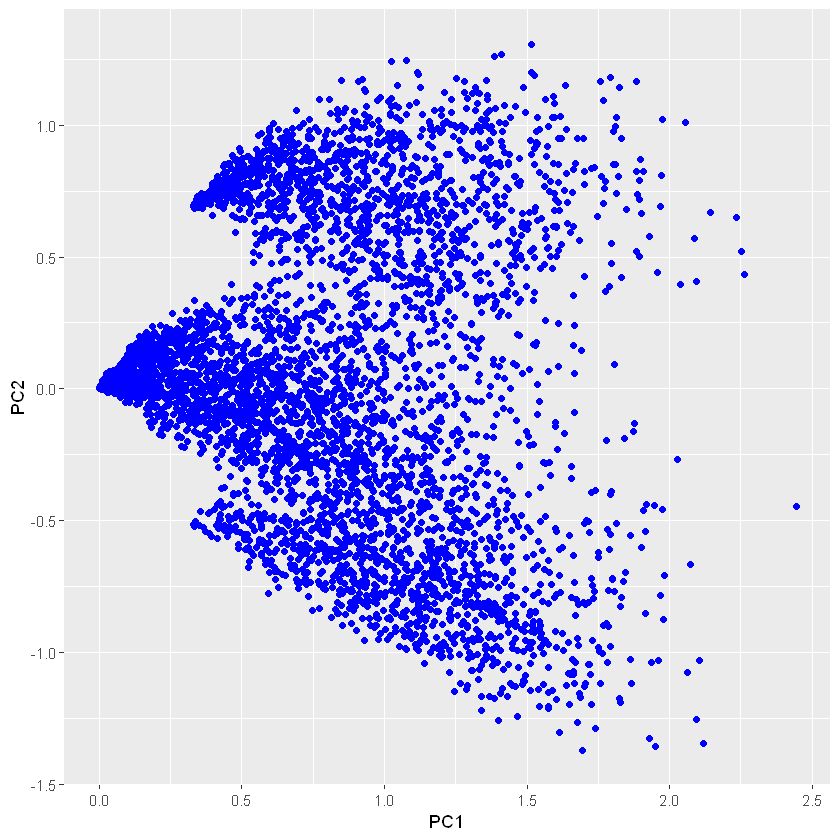

In [24]:

project = pca$rotation[,1:2]                             
# eigenvectors corresponding to first two principal components
project = data.frame(as.matrix(choices)%*%project)       
# project into two dimensions
ggplot(project, aes(PC1,PC2)) + geom_point(col='blue')


## Clustering

These clusters aren't necessarily the most well defined, but there appears to be some sort of structure to the data. We don't want to arbitrarily assign groups based on visual inspection, so using a clustering algorithm on this lower dimensional representation is a good idea. There are many clustering algorithms to choose from. Some of the most common are Gaussian Mixture Models (GMM) and K-Means.

In addition to choosing the clustering algorithm one typically selects the number of clusters. (There are algorithms where instead one will choose the size of the neighborhood). Let's look at GMM and K-Means where the optimal number of clusters is chosen through cross-validation based on the Silhouette Coefficient ( A measure of cluster separation and tightness ) 

In [25]:
# Defining a metric for "closest cluster" to assign test data to clusters

closest.cluster = function(x) {
  cluster.dist = apply(km$centers, 1, function(y) sqrt(sum((x-y)^2)))
  return(which.min(cluster.dist)[1])
}

# This is the same code as we used in the cross-validation module, 
# but a clustering algorithm instead of OLS

num_clust = 10                          
num_folds = 5  
sel = diag(num_folds)                                      
size = round(dim(project)[1]/num_folds)                
train = array(,dim=c(size*(num_folds-1),2,num_folds))      
test = array(,dim=c(size,2,num_folds))                     
sil = array(,c(num_folds,num_clust))                                
for (j in 2:num_clust){
    for (i in 1:num_folds){                                    
        test[,,i] = as.matrix(project)[as.logical(
            kronecker(array(1,c(size,1)),sel[i,])),]
        train[,,i] = as.matrix(project)[as.logical(
            kronecker(array(1,c(size,1)),(1-sel[i,]))),]
        train_tmp = data.frame(train[,,i])
        test_tmp = data.frame(test[,,i])
        
        # changes start here
        
        km = kmeans(train_tmp,j,nstart=10,iter.max=100)       
        # k-means algorithm with 10 restarts (pick best)
        clusters = apply(test_tmp, 1, closest.cluster)        
        # metric to assign test data to clusters 
        sil_tmp = silhouette(clusters,dist(test_tmp))         
        # compute silhouette for test data
        sil[i,j] = mean(sil_tmp[,3])
    }
}

In [26]:
cat('Lowest Silhouette achieved with', which.min(colMeans(sil)), 'Clusters')

Lowest Silhouette achieved with 9 Clusters

## What do we find?

According to the silhouette metric and the k-means algorithm the "best" number of clusters to use is 9. In this case we can interpret this as 9 different consumer types in our data set.

Now that we have optimized let's see what these clusters look like

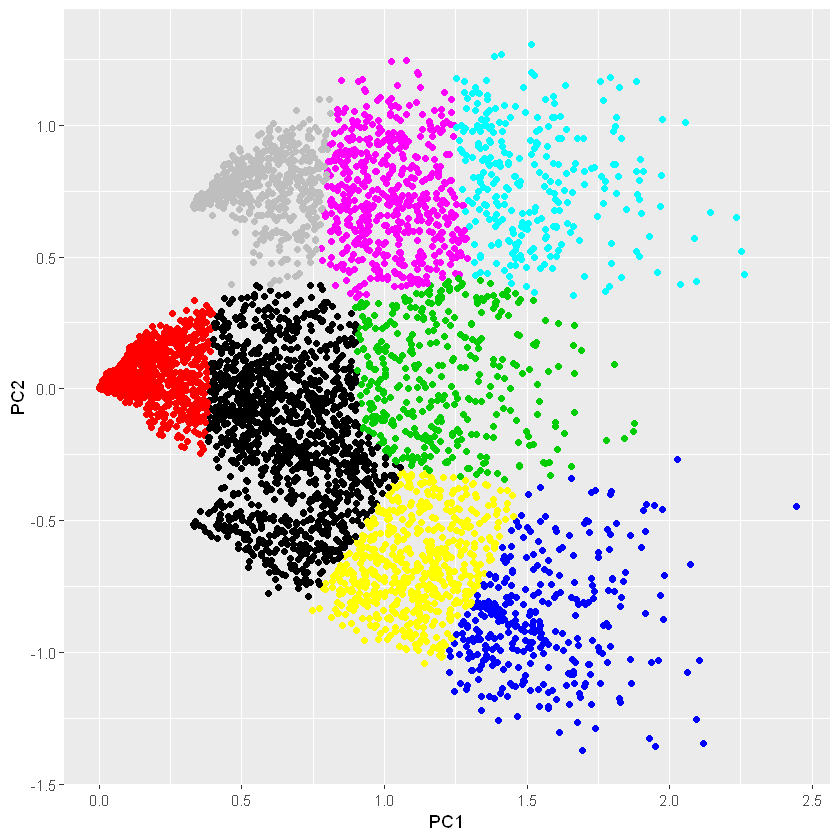

In [27]:
km = kmeans(project,which.min(colMeans(sil)),nstart=10,iter.max=100)
ggplot(project, aes(PC1,PC2)) + geom_point(col=km$cluster)

## Examination of Clusters

I don't think we would have chosen these clusters if we were simply eyeballing them. This makes things a bit tricky to interpret. Let's try a different clustering algorithm and see if the results are robust. 

## Guassian Mixture Model

The GMM clustering algorithm works similarly to the k-means algorithm except it attempts to fit $k$ normal distributions to the points using the EM algorithm. Once again the number of mixtures is something you need to provide to the algorithm. Once the number of mixtures is known, the algorithm will find the mean and covariance of each mixture. This is very easy to implement in R using the Mclust package.

In [28]:
gmm = Mclust(project)

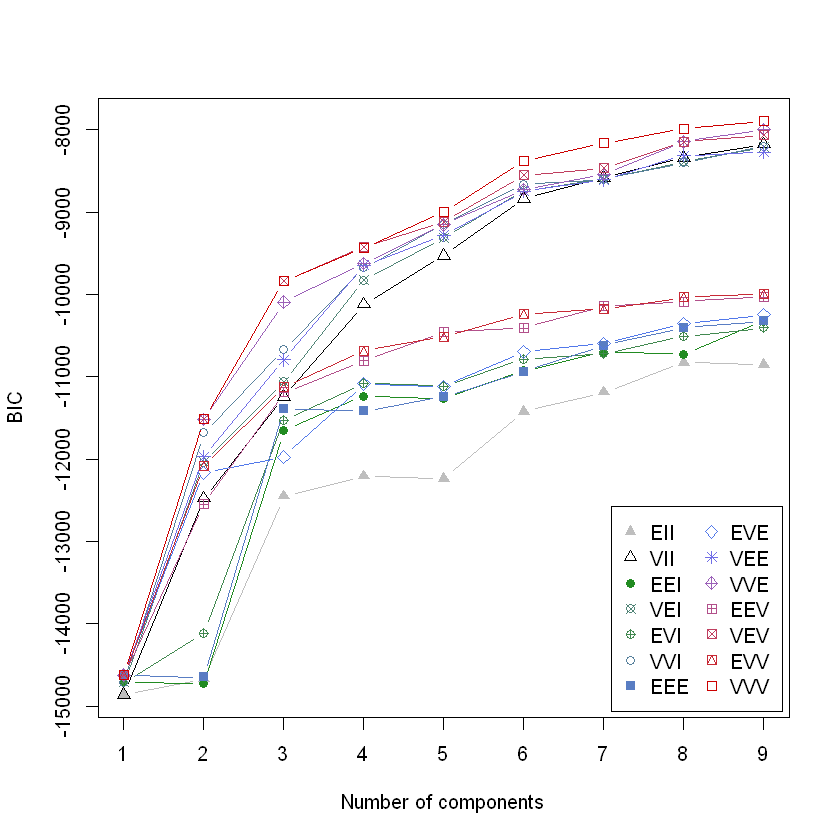

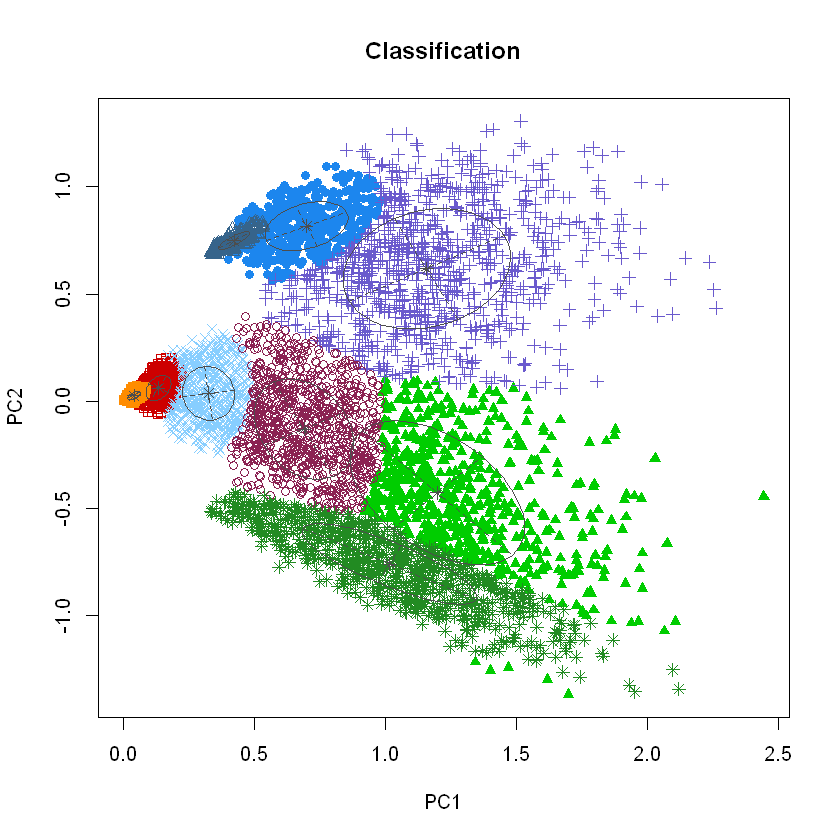

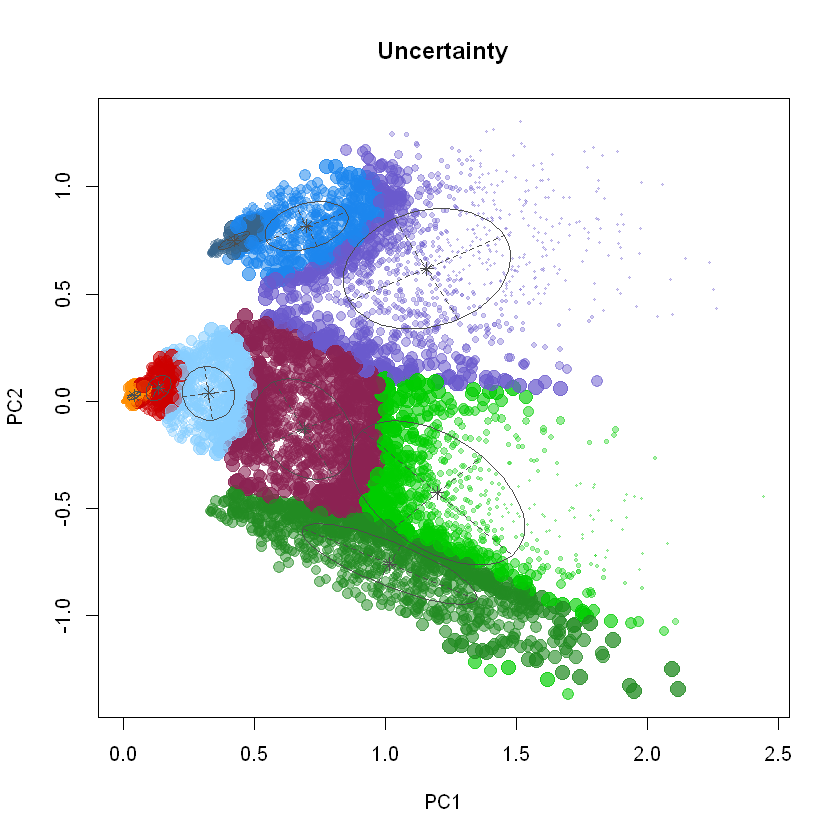

Bayesian Information Criterion (BIC): 
        EII        VII       EEI        VEI       EVI        VVI       EEE
1 -14859.65 -14859.649 -14709.26 -14709.256 -14709.26 -14709.256 -14623.86
2 -14671.30 -12477.106 -14728.31 -12035.953 -14113.01 -11679.363 -14650.81
3 -12453.43 -11243.314 -11654.26 -11061.297 -11527.04 -10669.897 -11390.80
4 -12209.83 -10119.942 -11236.05  -9828.886 -11079.35  -9678.363 -11417.11
5 -12235.41  -9528.640 -11261.62  -9309.178 -11112.13  -9145.575 -11242.62
6 -11422.58  -8838.800 -10929.60  -8743.660 -10786.33  -8662.645 -10938.13
7 -11187.66  -8585.244 -10701.56  -8598.129 -10718.13  -8604.174 -10620.46
8 -10827.51  -8337.907 -10727.11  -8390.416 -10510.54  -8399.731 -10405.31
9 -10852.91  -8175.586 -10325.37  -8210.137 -10407.36  -8205.900 -10326.46
        EVE        VEE        VVE       EEV        VEV        EVV        VVV
1 -14623.86 -14623.863 -14623.863 -14623.86 -14623.863 -14623.863 -14623.863
2 -12164.67 -11971.430 -11518.563 -12548.45 -11515.925 -1

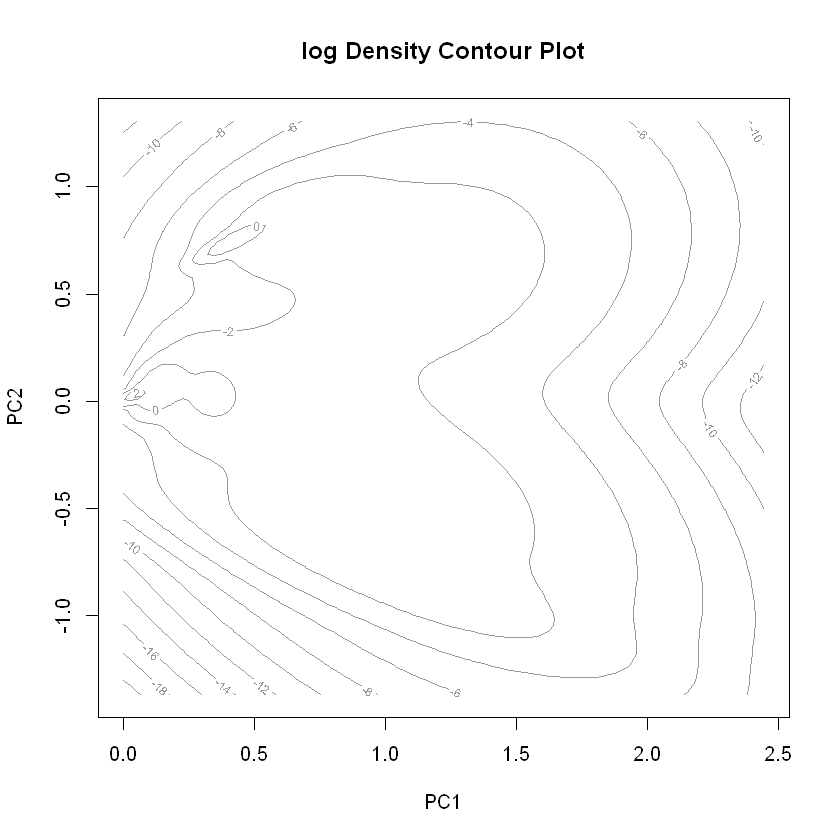

In [29]:
plot(gmm)
gmm$BIC

## Examination of GMM

Our results are robust in terms of the number of clusters. The GMM clustering algorithm also chooses 9 clusters, but assignment is not identical. One thing that is nice about GMM is that you get a measure of uncertainty when you compute cluster assignment. You can see that there is quite a bit of uncertainty in this result (The larger circles are more uncertain). This occurs because the groups do not have a lot of separation.

## Scree Plot

Recall that we used a two-dimensional projection so that we could visualize our data easily. However, this choice may not be "optimal" in the sense of maximizing the variation in the data without losing too much information. We can determine an "optimal" dimensionality reduction by looking at the scree plot (the magnitude of the ordered eigenvalues).

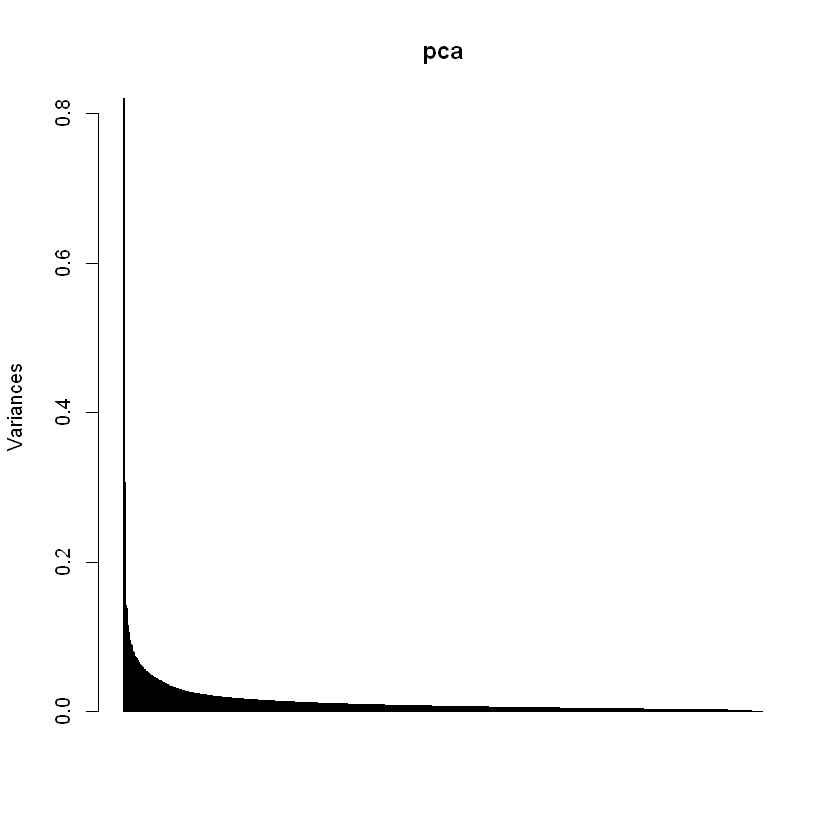

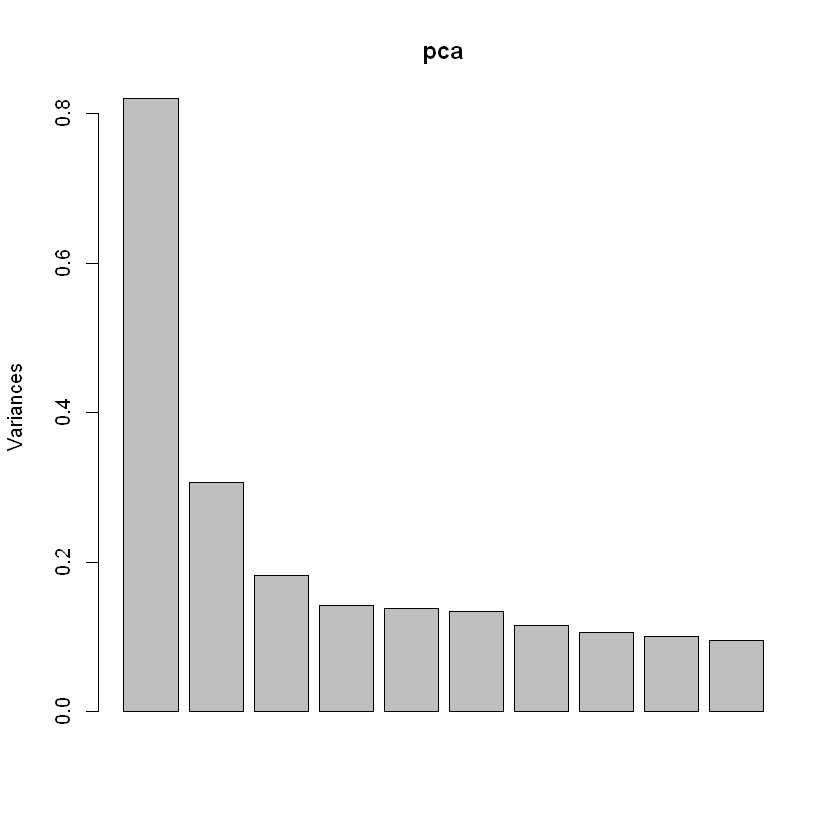

In [30]:
screeplot(pca,npcs=1000)
screeplot(pca,npcs=10)

## Examination of Scree Plot

The first image shows the scree plot for all of the eigenvalues and the second for only the first $10$. In the first case there are simply too many points to examine. When we zoom in on the first $10$ ordered eigenvalues we see that a lot of the variation is explained by only a few components. Even so, we may want to re-run those clustering algorithms on projections based on 3 or 4 eigenvalues to evaluate the robustness of our results.

## Exercise: Module 4

In this module we saw how to visualize high dimensional discrete data using a heatmap. We learned how to use PCA to project our high-dimensional data onto a two-dimensional surface. This procedure allowed us to visualize the variation in the data based on the first two eigenvalues. Given this projection we used two different clustering algorithms K-means and GMM to find the optimal number of clusters according to the silhouette metric for k-means and BIC for GMM. Finally we showed how a scree plot can help determine the "optimal" dimensionality reduction. We may also want to compute the principal components using the correlation matrix.

1. Using the prcomp function you can compute PCA using the correlation matrix by changing scale=TRUE
2. Project onto the two dimensional surface. Does it look different?
3. Run GMM on this embedding space. Is the optimal number of clusters different?



When the data is continuous this normalization can be extremely important. However, in the binary case the covariances are already bounded and so the scaling shouldn't matter much. In this case the normalization results in most of the variation being explained by the first component only. This actually makes the projection more difficult to cluster. However, if we look at the number of clusters chosen by BIC it is now <9. 